In [2]:
import os
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import random

In [9]:
num_classes = 80  # 分类数量
batch_size = 2
num_epochs = 10  # 训练轮次
lr = 0.02
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 读取并展示图片

file_root = "D:/aaaaaaaaaaaaaaaaa/nus/fyp/Q2A-master/Q2A-master/encoder/configs/train"
classes = ['aircon_utr3b','airfryer_gye82','airfryer_pe2j7','airfryer_w9rzm','bicycle_g8h94','blender_d4og8','blender_tg2xq','blender_zuw28','camera_4paj0','camera_9awdp','camera_a409h','coffeemachine_d2stw','dehydrator_jvzgp','diffuser_lxcd4','dryer_am5jp','dryer_d4uqs','dryer_vc1kl','inductioncooker_bjye3','inductioncooker_v0jzx','inductioncooker_veifx','kiettle_rc3pf','kitchenscale_025qs','kitchenscale_7shbw','kitchenscale_jsgih','kitchenscale_pqejy','kitchenscale_wk150','kitchentimer_fr3ld','kitchentimer_nr0vk','lightstand_ro8fj','microwave_clhpa','microwave_etrc9','microwave_gz61t','microwave_h43qm','microwave_kflra','microwave_ljbak','microwave_m0fgh','microwave_m5vq3','microwave_r5h7q','microwave_y3fpx','microwave_y693a','microwave_yw0gr','microwave_znl6u','mixer_muhce','oven_968hd','oven_e7fsy','oven_g6xvo','oven_lhap5','oven_un32d','oven_wa67l','oven_wn85g','printer_5jpry','printer_bf69n','rangehood_2pk8j','ricecooker_26ax0','ricecooker_5apek','ricecooker_af46c','ricecooker_tlvys','ricecooker_tomn0','ricecooker_zxuqy','toaster_ja9zg','toaster_xwc03','treadmill_npdev','treadmill_nu3ob','vacuum_1csuz','washingmachine_735oe','washingmachine_8fzkt','washingmachine_dz980','washingmachine_gxblk','washingmachine_h4n8j','washingmachine_kc4eb','washingmachine_kstcf','washingmachine_m79j0','washingmachine_tyap1','washingmachine_ujs4r','washingmachine_uomyf','washingmachine_wtbih','watch_0ku25','watch_c8zhg','watch_yw2mz','waterpurifier_b2j3o']
nums = [2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]  # 每种类别的个数

def read_data(path):
    file_name = os.listdir(path)  # 获取所有文件的文件名称
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    # 每个类别随机抽取20%作为测试集
    train_num = [int(num * 1 / 2) for num in nums]
    test_num = [nums[i] - train_num[i] for i in range(len(nums))]

    for idx, f_name in enumerate(file_name):  # 每个类别一个idx，即以idx作为标签
        im_dirs = path + '/' + f_name+'/images'
        im_path = os.listdir(im_dirs)  # 每个不同类别图像文件夹下所有图像的名称

        index = list(range(len(im_path)))
        random.shuffle(index)  # 打乱顺序
        im_path_ = list(np.array(im_path)[index])
        test_path = im_path_[:test_num[idx]]  # 测试数据的路径
        train_path = im_path_[test_num[idx]:]  # 训练数据的路径

        for img_name in train_path:
            # 会读到desktop.ini,要去掉
            if img_name == 'desktop.ini':
                continue
            img = Image.open(im_dirs + '/' + img_name).convert("RGB")  # img shape: (120, 85, 3) 高、宽、通道
            # 对图片进行变形
            img = img.resize((227, 227), Image.ANTIALIAS)  # 宽、高
            train_data.append(img)
            train_labels.append(idx)

        for img_name in test_path:
            # 会读到desktop.ini,要去掉
            if img_name == 'desktop.ini':
                continue
            img = Image.open(im_dirs + '/' + img_name).convert("RGB")  # img shape: (120, 85, 3) 高、宽、通道
            # 对图片进行变形
            img = img.resize((227, 227), Image.ANTIALIAS)  # 宽、高
            test_data.append(img)
            test_labels.append(idx)

    print('训练集大小：', len(train_data), ' 测试集大小：', len(test_data))

    return train_data, train_labels, test_data, test_labels

# 一次性读取全部的数据
train_data, train_labels, test_data, test_labels = read_data(file_root)

E:\anaconda\envs\dl\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
E:\anaconda\envs\dl\lib\site-packages\ipykernel_launcher.py:49: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.


训练集大小： 86  测试集大小： 80


In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),  # 变为tensor
     # 对数据按通道进行标准化，即减去均值，再除以方差, [0-1]->[-1,1]
     transforms.Normalize(mean=[0.4686, 0.4853, 0.5193], std=[0.1720, 0.1863, 0.2175])
     ]
)


# 自定义Dataset类实现每次取出图片，将PIL转换为Tensor
class MyDataset(Dataset):
    def __init__(self, data, label, trans):
        self.len = len(data)
        self.data = data
        self.label = label
        self.trans = trans

    def __getitem__(self, index):  # 根据索引返回数据和对应的标签
        return self.trans(self.data[index]), self.label[index]

    def __len__(self):
        return self.len


# 调用自己创建的Dataset
train_dataset = MyDataset(train_data, train_labels, transform)
test_dataset = MyDataset(test_data, test_labels, transform)

# 生成data loader
train_iter = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)
test_iter = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

In [11]:
def train(net, data_loader, device):
    net.train()  # 指定为训练模式
    train_batch_num = len(data_loader)
    total_loss = 0.0
    correct = 0  # 记录共有多少个样本被正确分类
    sample_num = 0

    # 遍历每个batch进行训练
    for data, target in data_loader:
        # 将图片和标签放入指定的device中
        data = data.to(device)
        target = target.to(device)
        # 将当前梯度清零
        optimizer.zero_grad()
        # 使用模型计算出结果
        y_hat = net(data)
        # 计算损失
        loss_ = loss(y_hat, target)
        # 进行反向传播
        loss_.backward()
        optimizer.step()
        total_loss += loss_.item()
        cor = (torch.argmax(y_hat, 1) == target).sum().item()
        correct += cor
        # 累加当前的样本总数
        sample_num += target.shape[0]
        print('loss: %.4f  acc: %.4f' % (loss_.item(), cor / target.shape[0]))
    # 平均loss和准确率
    loss_ = total_loss / train_batch_num
    acc = correct / sample_num
    return loss_, acc


# 测试
def test(net, data_loader, device):
    net.eval()  # 指定当前模式为测试模式（针对BN层和dropout层）
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    # 指定不进行梯度计算（没有反向传播也会计算梯度，增大GPU开销
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = net(data)
            loss_ = loss(output, target)
            total_loss += loss_.item()
            correct += (torch.argmax(output, 1) == target).sum().item()
            sample_num += target.shape[0]
    loss_ = total_loss / test_batch_num
    acc = correct / sample_num
    return loss_, acc

In [12]:
class AlexNet(torch.nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(3, 96, 11, 4), # in_channels, out_channels, kernel_size, stride, padding
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2), # kernel_size, stride
            # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            torch.nn.Conv2d(96, 256, 5, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            torch.nn.Conv2d(256, 384, 3, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(384, 384, 3, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(384, 256, 3, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, 2)
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1024, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 80),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output

In [13]:
net = AlexNet()
net.to(device)
# 损失函数和优化器
loss = torch.nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '0' # 下面老是报错 shape 不一致
import torch, gc

gc.collect()
torch.cuda.empty_cache()

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
num_epochs=1000

for epoch in range(num_epochs):
    # 在训练集上训练
    train_loss, train_acc = train(net, data_loader=train_iter, device=device)
    # 测试集上验证
    test_loss, test_acc = test(net, data_loader=test_iter, device=device)

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print('epoch %d, train loss: %.4f, train acc: %.3f' % (epoch+1, train_loss, train_acc))
    print('test loss: %.4f, test acc: %.3f' % (test_loss, test_acc))

loss: 3.7813  acc: 0.0000
loss: 4.0613  acc: 0.0000
loss: 3.6689  acc: 0.0000
loss: 4.5877  acc: 0.0000
loss: 3.7400  acc: 0.5000
loss: 1.8033  acc: 1.0000
loss: 3.2407  acc: 0.0000
loss: 2.1768  acc: 0.5000
loss: 4.7966  acc: 0.0000
loss: 1.6954  acc: 0.5000
loss: 2.7514  acc: 0.0000
loss: 5.1681  acc: 0.0000
loss: 0.6759  acc: 1.0000
loss: 2.4930  acc: 0.0000
loss: 1.0126  acc: 0.0000
loss: 1.9574  acc: 0.5000
loss: 3.5897  acc: 0.0000
loss: 2.7825  acc: 0.0000
loss: 6.8393  acc: 0.0000
loss: 3.5989  acc: 0.0000
loss: 3.8568  acc: 0.0000
loss: 3.9373  acc: 0.0000
loss: 5.1455  acc: 0.0000
loss: 3.5769  acc: 0.0000
loss: 4.8964  acc: 0.0000
loss: 4.1426  acc: 0.0000
loss: 3.4359  acc: 0.0000
loss: 3.1176  acc: 0.0000
loss: 4.2084  acc: 0.0000
loss: 3.9995  acc: 0.0000
loss: 3.0555  acc: 0.5000
loss: 2.5513  acc: 0.5000
loss: 3.0786  acc: 0.0000
loss: 3.3346  acc: 0.0000
loss: 2.7024  acc: 0.5000
loss: 4.5872  acc: 0.0000
loss: 4.0708  acc: 0.0000
loss: 2.3932  acc: 0.0000
loss: 6.7499

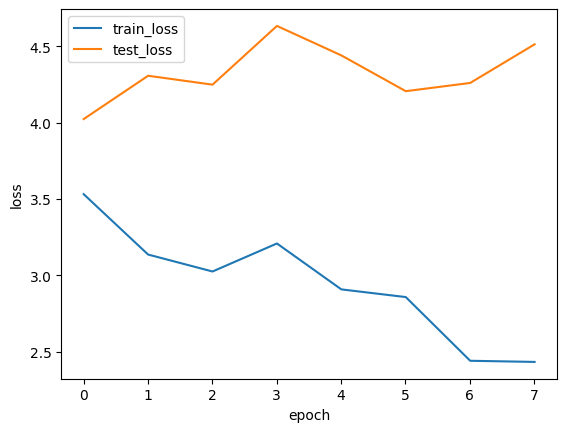

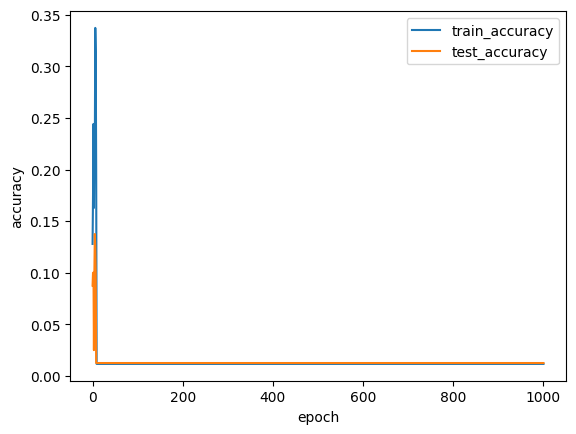

In [17]:
def draw_(x, train_Y, test_Y, ylabel):
    plt.plot(x, train_Y, label='train_' + ylabel, linewidth=1.5)
    plt.plot(x, test_Y, label='test_' + ylabel, linewidth=1.5)
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    plt.legend()  # 加上图例
    plt.show()


# 绘制loss曲线
x = np.linspace(0, len(train_loss_list), len(train_loss_list))
draw_(x, train_loss_list, test_loss_list, 'loss')
draw_(x, train_acc_list, test_acc_list, 'accuracy')